# Setup

## 참고문서
- https://wikidocs.net/book/14314
- https://wikidocs.net/book/14473

## OpenAI Key 등록
- [OpenAI Key 발급](https://platform.openai.com/api-keys)
- [OpenAI 요금](https://platform.openai.com/settings/organization/billing/overview)

In [1]:
import os

os.environ['OPENAI_API_KEY'] = '생성한 키 입력'

## 구글 드라이브 연결

In [4]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive

    drive.mount('/content/data')
    DATA_PATH = "/content/data/MyDrive/ai_lecture/3. Large Language Models/data/"
except:
    DATA_PATH = "./data/"

Mounted at /content/data


## install

In [5]:
!pip install -U langchain sentence-transformers langchain_community langchain-huggingface pdfplumber pymupdf faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290

# [Evaluations](https://wikidocs.net/259203)

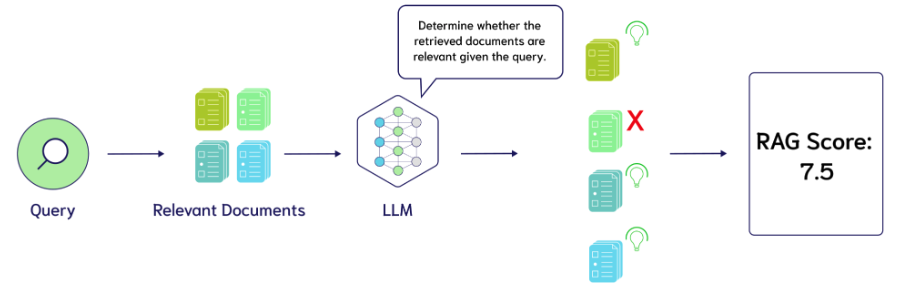

## Evaluation Score

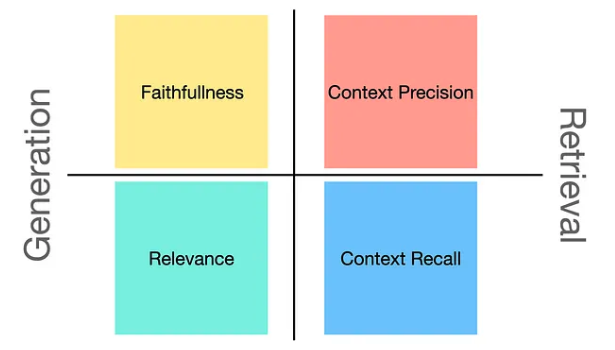

### Generation Metrics

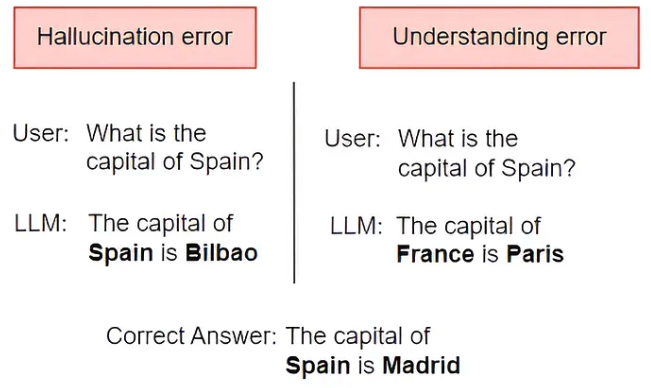

#### Answer Relevancy

- Answer Relevancy는 생성된 답변이 주어진 prompt에 얼마나 적절한지를 평가하는 지표입니다. 이 지표의 주요 특징과 계산 방법을 요약하면 다음과 같습니다:
  - `목적`: 생성된 답변의 관련성을 평가합니다.
  - `점수 해석`: 낮은 점수는 불완전하거나 중복 정보를 포함한 답변을, 높은 점수는 더 나은 관련성을 나타냅니다.
  - `계산에 사용되는 요소`: question, context, answer

- Answer Relevancy의 계산 방법: - 원래 question과 answer를 기반으로 생성된 인공적인 질문들 간의 평균 코사인 유사도로 정의됩니다.
  - $E_{g_i}$는 생성된 질문 $i$의 임베딩
  - $E_o$는 원래 질문의 임베딩
  - $N$은 생성된 질문의 수 (기본값 3)
$$
answer\; relevancy = { 1 \over N } \sum{cos(E_{g_i},\; E_{o})}
$$
또는
$$
answer\; relevancy = { 1 \over N } \sum{{ E_{g_i}E_{o} \over |E_{g_i}||E_{o}| }}
$$

- 주의사항: 실제로는 점수가 대부분 0과 1 사이에 있지만, 코사인 유사도의 특성상 수학적으로 -1에서 1 사이의 값을 가질 수 있습니다.
- 이 지표는 질문-답변 시스템의 성능을 평가하는 데 유용하며, 특히 생성된 답변이 원래 질문의 의도를 얼마나 잘 반영하는지를 측정합니다.


#### Faithfulness

- Faithfulness는 생성된 답변의 사실적 일관성을 주어진 컨텍스트와 비교하여 측정하는 지표입니다. 주요 특징은 다음과 같습니다:
  - `목적`: 답변의 사실적 일관성을 컨텍스트와 비교하여 평가합니다.
  - `계산 요소`: 답변과 검색된 컨텍스트를 사용합니다.
  - `점수 범위`: 0에서 1 사이로 조정되며, 높을수록 더 좋습니다.

- Faithfulness 점수 계산 방법:

$$
Faithfulness\; score = { |Number\; of\; claims\; in\; the\; generated\; answer\; that\; can\; be\; inferred\; from\; given\; context| \over |Total\; number\; of\; claims\; in\; the\; generated\; answer| }
$$

- 계산 과정:
  1. 생성된 답변에서 주장(claims)들을 식별합니다.
  2. 각 주장을 주어진 컨텍스트와 대조 검증하여 컨텍스트에서 추론 가능한지 확인합니다.
  3. 위 수식을 사용하여 점수를 계산합니다.

- 예시
  - `질문`: "아인슈타인은 어디서, 언제 태어났나요?"
  - `컨텍스트`: "알버트 아인슈타인(1879년 3월 14일 출생)은 독일 출신의 이론 물리학자로, 역사상 가장 위대하고 영향력 있는 과학자 중 한 명으로 여겨집니다."
  - `높은 충실도 답변`: "아인슈타인은 1879년 3월 14일 독일에서 태어났습니다."
  - `낮은 충실도 답변`: "아인슈타인은 1879년 3월 20일 독일에서 태어났습니다."

### [Retrieval Metrics](https://www.pinecone.io/learn/series/vector-databases-in-production-for-busy-engineers/rag-evaluation/)

#### Context Precision(Precision@k)
- Context Precision은 contexts 내의 ground-truth 관련 항목들이 상위 순위에 있는지를 평가하는 지표입니다.
- 이상적으로는 모든 관련 chunks가 상위 순위에 나타나야 합니다.
- 이 지표는 question, ground_truth, 그리고 contexts를 사용하여 계산되며, 0에서 1 사이의 값을 가집니다.
- 높은 점수일수록 더 나은 정밀도를 나타냅니다.

$$
Precision@k = { true\; positives@k \over (true\; positives@k) + (false\; positives@k) }
$$

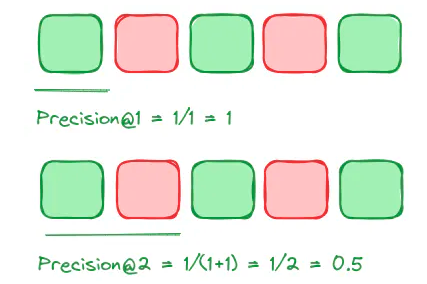

#### Context Recall(Recall@k)
- Context recall은 검색된 context가 LLM 이 생성한 답변과 얼마나 일치하는지를 측정합니다.
- 이는 question, ground truth 및 검색된 context를 사용하여 계산되며, 값은 0에서 1 사이로, 높을수록 더 나은 성능을 나타냅니다.
- Ground truth 답변에서 context recall을 추정하기 위해, ground truth 답변의 각 주장이 검색된 context에 귀속될 수 있는지 분석됩니다. 이상적인 시나리오에서는 ground truth 답변의 모든 주장이 검색된 context에 귀속될 수 있어야 합니다.

$$
Recall@k = { true\; positives@k \over (true\; positives@k) + (false\; negatives@k) }
$$

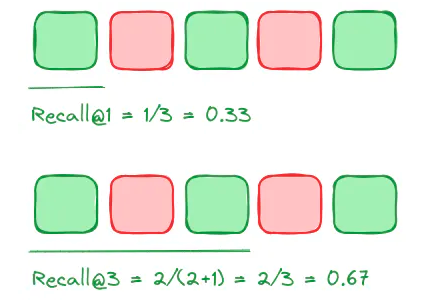

## [RAGAS](https://docs.ragas.io/en/latest/concepts/testset_generation.html)

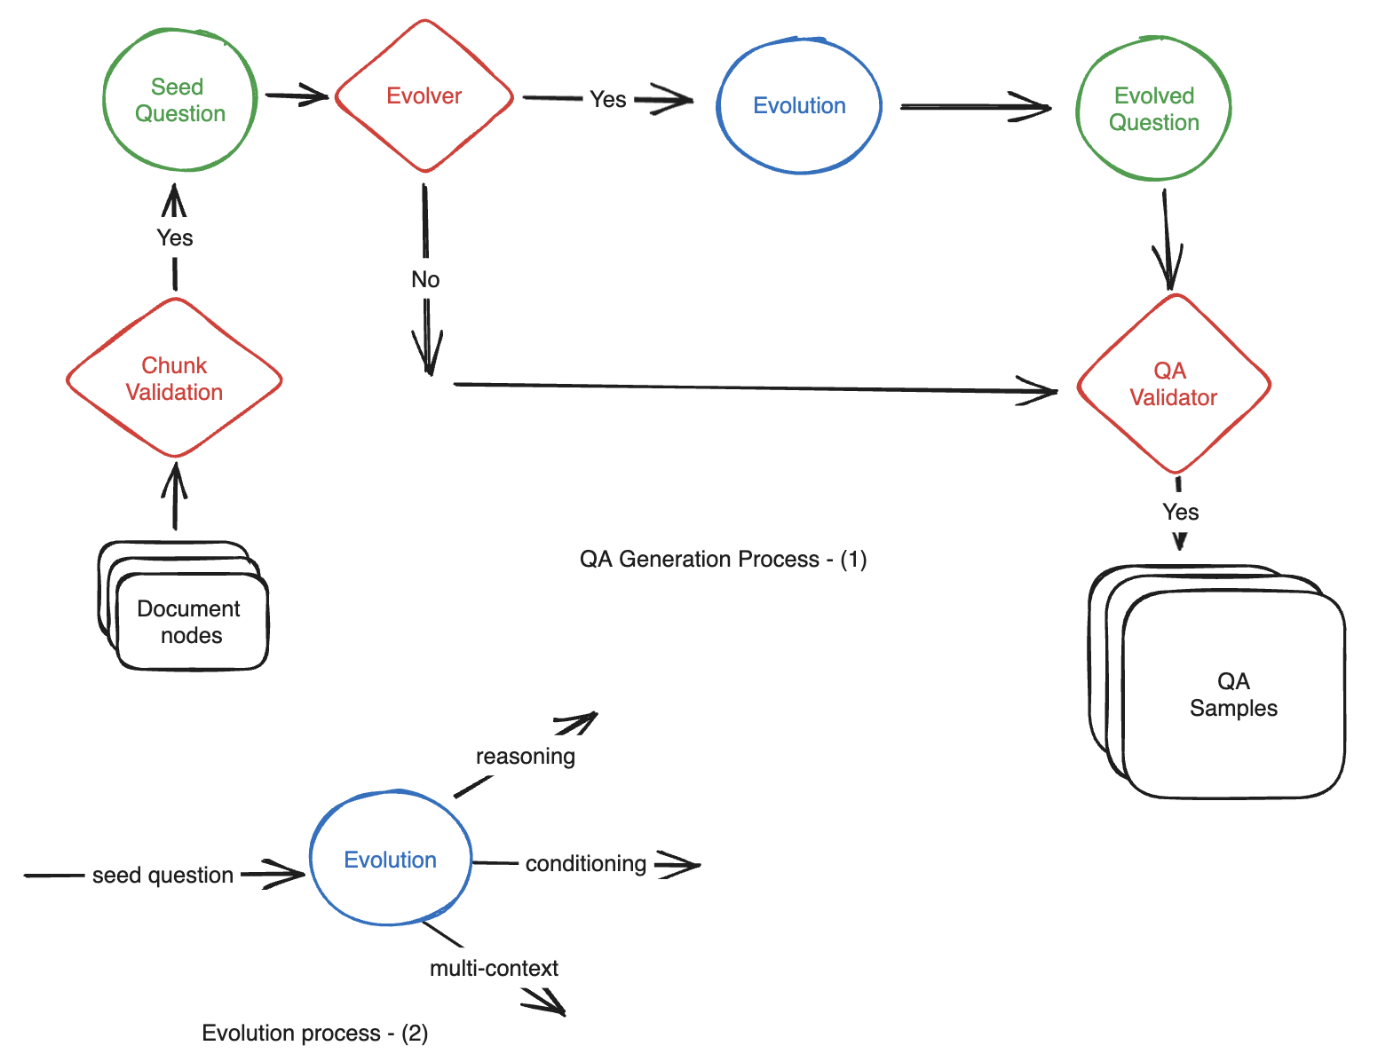

### install ragas

In [6]:
!pip install git+https://github.com/explodinggradients/ragas

  Cloning https://github.com/explodinggradients/ragas to /tmp/pip-req-build-8ffloylo
  Running command git clone --filter=blob:none --quiet https://github.com/explodinggradients/ragas /tmp/pip-req-build-8ffloylo
  Resolved https://github.com/explodinggradients/ragas to commit 495bbd1acf7fbc5a978edf22576f467cf2d5bc96
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of langchain to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.0/397.0 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━

### [데이터셋 생성](https://docs.ragas.io/en/latest/getstarted/testset_generation.html)

#### 문서 전처리

In [6]:
from langchain_community.document_loaders import PDFPlumberLoader

# 문서 로더 생성
loader = PDFPlumberLoader(DATA_PATH+"SPRI_AI_Brief_2023년12월호_F.pdf")

# 문서 로딩
documents = loader.load()

In [7]:
# 목차, 끝 페이지 제외
documents = documents[3:-1]

# 문서의 페이지수
len(documents)

19

In [8]:
documents[:1]

[Document(metadata={'source': '/content/data/MyDrive/ai_lecture/3. Large Language Models/data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': '/content/data/MyDrive/ai_lecture/3. Large Language Models/data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 3, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육\n미국, 안전하고 신뢰할 수 있는 AI 개발과 사용에 관한 행정명령 발표\nKEY Contents\nn 미국 바이든 대통령이 ‘안전하고 신뢰할 수 있는 AI 개발과 사용에 관한 행정명령’에 서명하고\n광범위한 행정 조치를 명시\nn 행정명령은 △AI의 안전과 보안 기준 마련 △개인정보보호 △형평성과 시민권 향상 △소비자\n보호 △노동자 지원 △혁신과 경쟁 촉진 △국제협력을 골자로 함\n£바이든 대통령, AI 행정명령 통해 안전하고 신뢰할 수 있는 AI 개발과 활용 추진\nn 미국 바이든 대통령이 2023년 10월 30일 연방정부 차원에서 안전하고 신뢰할 수 있는 AI 개발과\n사용을 보장하기 위한 행정명령을 발표\n∙ 행정명령은 △AI의 안전과 보안 기준 마련 △개인정보보호 △형평성과 시민권 향상 △소비자 보호\n△노동자 지원 △혁신과 경쟁 촉진 △국제협력에 관한 내용을 포괄\nn (AI 안전과 보안 기준) 강력한 AI 시스템을 개발하는 기업에게 안전 테스트 결과와 시스템

- 각 문서 객체에는 `metadata` 를 통해 액세스할 수 있는 문서에 대한 추가 정보를 저장하는 데 사용할 수 있는 메타데이터 사전이 포함되어 있습니다.
- 메타데이터 사전에는 `filename` 이라는 키가 포함되어 있는지 확인하세요.
- 이 키는 `Test datasets` 생성 프로세스에서 활용될 것이므로, 메타데이터의 `filename` 속성은 동일한 문서에 속한 청크를 식별하는 데 사용됩니다.

In [9]:
# metadata 설정(filename 이 존재해야 함)
for doc in documents:
    doc.metadata["filename"] = doc.metadata["source"]


#### TestsetGenerator

In [10]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context, conditional
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset.extractor import KeyphraseExtractor
from ragas.testset.docstore import InMemoryDocumentStore

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 데이터셋 생성기
generator_llm = ChatOpenAI(model="gpt-4o-mini")
# 데이터셋 비평기
critic_llm = ChatOpenAI(model="gpt-4o-mini")
# 문서 임베딩
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")


In [11]:
generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

- `simple`: 간단한 질문
- `reasoning`: 추론이 필요한 질문
- `multi_context`: 여러 맥락을 고려해야 하는 질문
- `conditional`: 조건부 질문

In [12]:
# 질문 유형별 분포 결정
# simple: 간단한 질문, reasoning: 추론이 필요한 질문, multi_context: 여러 맥락을 고려해야 하는 질문, conditional: 조건부 질문
distributions = {simple: 0.4, reasoning: 0.2, multi_context: 0.2, conditional: 0.2}


- `documents`: 문서 데이터
- `test_size`: 생성할 질문의 수
- `distributions`: 질문 유형별 분포
- `with_debugging_logs`: 디버깅 로그 출력 여부

In [13]:
# 테스트셋 생성
# docs: 문서 데이터, 10: 생성할 질문의 수, distributions: 질문 유형별 분포, with_debugging_logs: 디버깅 로그 출력 여부
testset = generator.generate_with_langchain_docs(
    documents=documents, test_size=10, distributions=distributions
)


embedding nodes:   0%|          | 0/108 [00:00<?, ?it/s]

Generating:   0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
# 생성된 테스트셋을 pandas DataFrame으로 변환
test_df = testset.to_pandas()

# DataFrame의 상위 5개 행 출력
test_df.head()

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What is the significance of making AI forget a...,"[,\n학계, 시민사회 및 일반 대중과 정보 공유 채널을 구축\n∙ AI 안전성 정...",The answer to given question is not present in...,simple,[{'source': '/content/data/MyDrive/ai_lecture/...,True
1,What is the significance of LLM in the context...,[포함한 질문과 답변 △RAG\n없는 질문과 답변 △긴 형식의 텍스트(보고서나 기사...,The significance of LLM in the context of RAG ...,simple,[{'source': '/content/data/MyDrive/ai_lecture/...,True
2,What specific types of AI policy recommendatio...,"[SPRi AI Brief |\n2023-12월호\nG7, 히로시마 AI 프로세스를...",The answer to given question is not present in...,simple,[{'source': '/content/data/MyDrive/ai_lecture/...,True
3,What are the performance metrics used to evalu...,[�요\n∙ (범용성과 성능을 모두 평가) 진정한 AGI는 인간을 능가하는 폭넓은 ...,The answer to given question is not present in...,simple,[{'source': '/content/data/MyDrive/ai_lecture/...,True
4,What can we learn about data transparency from...,"[ 법적 프레임\n워크의 필요성을 제기\n∙ 일례로 데이터를 수집한 지역, 모델 훈...",The answer to given question is not present in...,reasoning,[{'source': '/content/data/MyDrive/ai_lecture/...,True


- DataFrame을 CSV 파일로 저장

In [17]:
# DataFrame을 CSV 파일로 저장
test_df.to_csv("./ragas_synthetic_dataset.csv", index=False)

#### 평가 데이터셋 생성

In [7]:
import pandas as pd

df = pd.read_csv(DATA_PATH+"ragas_synthetic_dataset.csv")
df.head()

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What is the significance of making AI forget a...,"[',\n학계, 시민사회 및 일반 대중과 정보 공유 채널을 구축\n∙ AI 안전성 ...",The answer to given question is not present in...,simple,[{'source': '/content/data/MyDrive/ai_lecture/...,True
1,What is the significance of LLM in the context...,['포함한 질문과 답변 △RAG\n없는 질문과 답변 △긴 형식의 텍스트(보고서나 기...,The significance of LLM in the context of RAG ...,simple,[{'source': '/content/data/MyDrive/ai_lecture/...,True
2,What specific types of AI policy recommendatio...,"['SPRi AI Brief |\n2023-12월호\nG7, 히로시마 AI 프로세스...",The answer to given question is not present in...,simple,[{'source': '/content/data/MyDrive/ai_lecture/...,True
3,What are the performance metrics used to evalu...,['�요\n∙ (범용성과 성능을 모두 평가) 진정한 AGI는 인간을 능가하는 폭넓은...,The answer to given question is not present in...,simple,[{'source': '/content/data/MyDrive/ai_lecture/...,True
4,What can we learn about data transparency from...,"[' 법적 프레임\n워크의 필요성을 제기\n∙ 일례로 데이터를 수집한 지역, 모델 ...",The answer to given question is not present in...,reasoning,[{'source': '/content/data/MyDrive/ai_lecture/...,True


In [8]:
from datasets import Dataset

test_dataset = Dataset.from_pandas(df)
test_dataset


Dataset({
    features: ['question', 'contexts', 'ground_truth', 'evolution_type', 'metadata', 'episode_done'],
    num_rows: 9
})

In [9]:
import ast

def convert_to_list(example):
    contexts = ast.literal_eval(example["contexts"])
    return {"contexts": contexts}


test_dataset = test_dataset.map(convert_to_list)
test_dataset

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'contexts', 'ground_truth', 'evolution_type', 'metadata', 'episode_done'],
    num_rows: 9
})

In [10]:
test_dataset[0]

{'question': 'What is the significance of making AI forget about copyrighted material?',
 'contexts': [',\n학계, 시민사회 및 일반 대중과 정보 공유 채널을 구축\n∙ AI 안전성 정상회의(AI Safety Summit)에서 합의된 대로 첨단 AI 모델의 평가 후 해당 모델이 배포된\n타국의 정부 및 연구소와 평가 결과를 공유하고, 학계와 대중이 AI 시스템의 피해와 취약점을 보고할 수\n있는 명확한 절차를 수립\n☞ 출처 : Gov.uk, Introducing the AI Safety Institute, 2023.11.02.\nVenturebeat, Researchers turn to Harry Potter to make AI forget about copyrighted material, 2023.10.06.\n'],
 'ground_truth': 'The answer to given question is not present in context',
 'evolution_type': 'simple',
 'metadata': '[{\'source\': \'/content/data/MyDrive/ai_lecture/3. Large Language Models/data/SPRI_AI_Brief_2023년12월호_F.pdf\', \'file_path\': \'/content/data/MyDrive/ai_lecture/3. Large Language Models/data/SPRI_AI_Brief_2023년12월호_F.pdf\', \'page\': 17, \'total_pages\': 23, \'Author\': \'dj\', \'Creator\': \'Hwp 2018 10.0.0.13462\', \'Producer\': \'Hancom PDF 1.3.0.542\', \'CreationDate\': "D:20231208132838+09\'00\'", \'ModDate\': "D:2023

To evaluate the RAG pipeline, RAGAs expects the following information:
- `question`: The user query that is the input of the RAG pipeline. The input.
- `answer`: The generated answer from the RAG pipeline. The output.
- `contexts`: The contexts retrieved from the external knowledge source used to answer the question.
- `ground_truths`: The ground truth answer to the question. This is the only human-annotated information. This information is only required for the metric `context_recall`.

#### 배치 데이터셋 생성
- 배치 데이터셋을 생성합니다. 배치 데이터셋은 다량의 질문을 한 번에 처리할 때 용이합니다.

In [11]:
batch_dataset = [question for question in test_dataset["question"]]
batch_dataset[:3]

['What is the significance of making AI forget about copyrighted material?',
 'What is the significance of LLM in the context of RAG and its applications?',
 'What specific types of AI policy recommendations, such as ethical guidelines or regulatory frameworks, were discussed at the AI Safety Summit in November 2023?']

### RAG

In [32]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

#### 단계 1: 문서 로드(Load Documents)

In [33]:
loader = PyMuPDFLoader(DATA_PATH+"SPRI_AI_Brief_2023년12월호_F.pdf")
docs = loader.load()

#### 단계 2: 문서 분할(Split Documents)

In [34]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
split_documents = text_splitter.split_documents(docs)

#### 단계 3: 임베딩(Embedding) 생성

In [35]:
embeddings = OpenAIEmbeddings()

#### 단계 4: DB 생성(Create DB) 및 저장

In [36]:
# 벡터스토어를 생성합니다.
vectorstore = FAISS.from_documents(documents=split_documents, embedding=embeddings)

#### 단계 5: 검색기(Retriever) 생성

In [37]:
# 문서에 포함되어 있는 정보를 검색하고 생성합니다.
retriever = vectorstore.as_retriever()

#### 단계 6: 프롬프트 생성(Create Prompt)

In [38]:
# 프롬프트를 생성합니다.
prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.

#Context:
{context}

#Question:
{question}

#Answer:"""
)

### [RAGAS with ChatOpenAI](https://wikidocs.net/259203)

#### ChatOpenAI를 통한 answer 생성
- LLM을 통한 답변 생성

In [39]:
# 언어모델(LLM) 생성
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

In [40]:
# 체인(Chain) 생성
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)


- `batch()` 를 호출하여 배치 데이터셋에 대한 답변을 받습니다.

In [41]:
answer = chain.batch(batch_dataset)
answer[:3]

["The significance of making AI forget about copyrighted material lies in addressing legal and ethical concerns related to copyright infringement. As highlighted in the provided context, AI models often reference various artists' works when generating new images. If these models use copyrighted material without proper authorization, it can lead to legal disputes over copyright infringement. For instance, the context mentions a case where artists sued AI companies for using their works without consent to train AI models. The court dismissed the case partly because the artists' works were not registered with the copyright office, and it was challenging to prove substantial similarity between the AI-generated images and the original works.\n\nBy ensuring that AI systems do not retain or use copyrighted material without permission, it helps in:\n1. **Avoiding Legal Issues**: Prevents potential lawsuits and legal complications related to unauthorized use of copyrighted content.\n2. **Respec

- LLM 이 생성한 답변을 'answer' 컬럼에 저장합니다.

In [43]:
# 'answer' 컬럼 덮어쓰기 또는 추가
if "answer" in test_dataset.column_names:
    test_dataset = test_dataset.remove_columns(["answer"]).add_column("answer", answer)
else:
    test_dataset = test_dataset.add_column("answer", answer)


In [45]:
test_dataset

Dataset({
    features: ['question', 'contexts', 'ground_truth', 'evolution_type', 'metadata', 'episode_done', 'answer'],
    num_rows: 9
})

In [46]:
# 생성된 테스트셋을 pandas DataFrame으로 변환
test_dataset.to_pandas().head()

,question,contexts,ground_truth,evolution_type,metadata,episode_done,answer
0,What is the significance of making AI forget a...,"[,\n학계, 시민사회 및 일반 대중과 정보 공유 채널을 구축\n∙ AI 안전성 정...",The answer to given question is not present in...,simple,[{'source': '/content/data/MyDrive/ai_lecture/...,True,The significance of making AI forget about cop...
1,What is the significance of LLM in the context...,[포함한 질문과 답변 △RAG\n없는 질문과 답변 △긴 형식의 텍스트(보고서나 기사...,The significance of LLM in the context of RAG ...,simple,[{'source': '/content/data/MyDrive/ai_lecture/...,True,The significance of Large Language Models (LLM...
2,What specific types of AI policy recommendatio...,"[SPRi AI Brief |\n2023-12월호\nG7, 히로시마 AI 프로세스를...",The answer to given question is not present in...,simple,[{'source': '/content/data/MyDrive/ai_lecture/...,True,The AI Safety Summit in November 2023 discusse...
3,What are the performance metrics used to evalu...,[�요\n∙ (범용성과 성능을 모두 평가) 진정한 AGI는 인간을 능가하는 폭넓은 ...,The answer to given question is not present in...,simple,[{'source': '/content/data/MyDrive/ai_lecture/...,True,The performance metrics used to evaluate AGI (...
4,What can we learn about data transparency from...,"[ 법적 프레임\n워크의 필요성을 제기\n∙ 일례로 데이터를 수집한 지역, 모델 훈...",The answer to given question is not present in...,reasoning,[{'source': '/content/data/MyDrive/ai_lecture/...,True,"From Cohere's Data Provenance Explorer, we can..."


#### answer 평가 by RAGAS

In [47]:
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)

In [48]:
result = evaluate(
    dataset=test_dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ],
)

result

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

{'context_precision': 0.4444, 'faithfulness': 0.6168, 'answer_relevancy': 0.9532, 'context_recall': 0.8889}

In [49]:
result_df = result.to_pandas()
result_df.head()

,question,contexts,answer,ground_truth,context_precision,faithfulness,answer_relevancy,context_recall
0,What is the significance of making AI forget a...,"[,\n학계, 시민사회 및 일반 대중과 정보 공유 채널을 구축\n∙ AI 안전성 정...",The significance of making AI forget about cop...,The answer to given question is not present in...,0.0,0.615385,1.000000,1.0
1,What is the significance of LLM in the context...,[포함한 질문과 답변 △RAG\n없는 질문과 답변 △긴 형식의 텍스트(보고서나 기사...,The significance of Large Language Models (LLM...,The significance of LLM in the context of RAG ...,1.0,0.708333,0.815309,1.0
2,What specific types of AI policy recommendatio...,"[SPRi AI Brief |\n2023-12월호\nG7, 히로시마 AI 프로세스를...",The AI Safety Summit in November 2023 discusse...,The answer to given question is not present in...,0.0,1.000000,0.974138,1.0
3,What are the performance metrics used to evalu...,[�요\n∙ (범용성과 성능을 모두 평가) 진정한 AGI는 인간을 능가하는 폭넓은 ...,The performance metrics used to evaluate AGI (...,The answer to given question is not present in...,0.0,0.000000,0.967691,1.0
4,What can we learn about data transparency from...,"[ 법적 프레임\n워크의 필요성을 제기\n∙ 일례로 데이터를 수집한 지역, 모델 훈...","From Cohere's Data Provenance Explorer, we can...",The answer to given question is not present in...,0.0,0.586207,0.945243,1.0


In [50]:
result_df.loc[:, "context_precision":"context_recall"]

,context_precision,faithfulness,answer_relevancy,context_recall
0,0.0,0.615385,1.000000,1.0
1,1.0,0.708333,0.815309,1.0
2,0.0,1.000000,0.974138,1.0
3,0.0,0.000000,0.967691,1.0
4,0.0,0.586207,0.945243,1.0
5,1.0,0.928571,0.998244,1.0
6,0.0,0.000000,0.939313,1.0
7,1.0,0.823529,0.940926,0.0
8,1.0,0.888889,0.998380,1.0


# [LangGraph](https://wikidocs.net/233785)

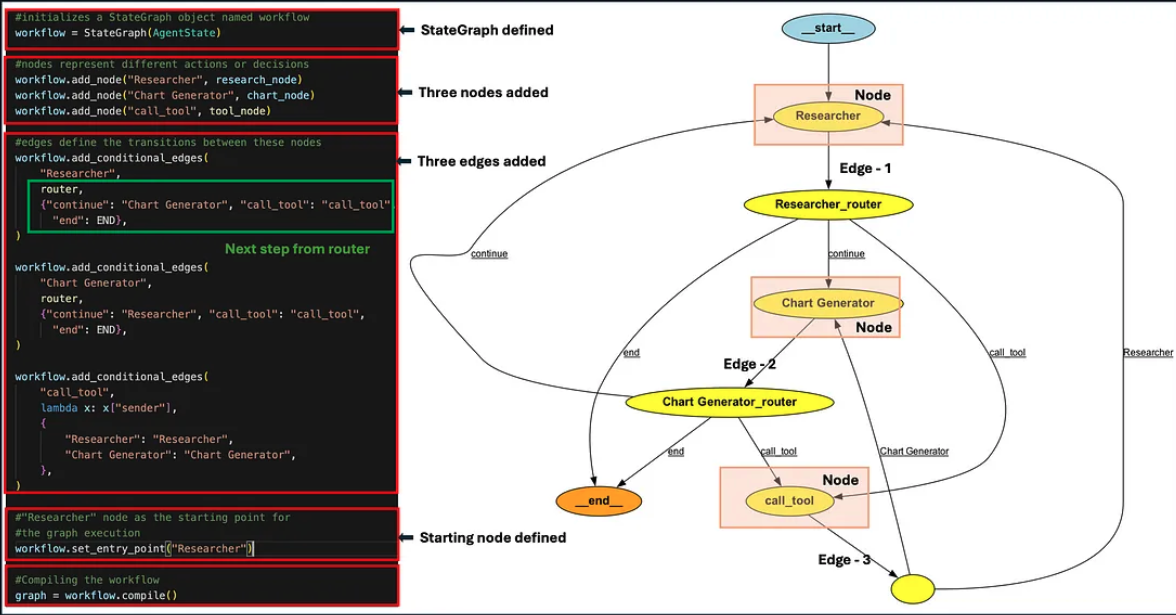

- https://haystack.deepset.ai/cookbook/rag_eval_ragas